In [1]:
import os, glob
import copy
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 200)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import rankdata
from scipy import stats
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import mixture
from math import pi
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from kneed import DataGenerator, KneeLocator

cwd = os.getcwd()
today = datetime.today().strftime('%Y-%m-%d')

print(cwd)
print(today)

/home/cst/SmartTradzt/PriceSegmentation
2021-07-15


In [2]:
min_cluster = 3

In [3]:
filename = 'Polymer Spot Sales Contract v2.xlsx'
filepath = os.path.join(cwd,'InternalData',filename)
print(filepath)

/home/cst/SmartTradzt/PriceSegmentation/InternalData/Polymer Spot Sales Contract v2.xlsx


In [4]:
data = pd.read_excel(filepath,sheet_name='Polymer Spot Sales Contract')

In [5]:
data['Price Premium Pctg'] = data['Price Premium']/data['REFERENCE_MARKET_PRICE']

In [6]:
data['Customer Industry'].fillna('No Customer Industry',inplace=True)
data['Customer Type'].fillna('No Customer Type',inplace=True)
data['Cross Boarder'].fillna('No Cross Boarder',inplace=True)

In [7]:
data.head()

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer Type,Customer Industry,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,Price Premium Pctg
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000,0.059594
1,2017-11-22,QTN-0000013779-1,1,30012429,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,Distributor / Trader,Mfg-Petroleum Prod,C150Y,72000448,TT60SBLC,CFR,Bangladesh,BDCGP CHITTAGONG,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M059,2018-01-10,2018-01-03,4.22,306.0,MT,USD,1290.0,1235.58130,1288.75,-53.16870,1290.0,41.669931,1279.999931,-0.041256
2,2017-09-11,QTN-0000012648-1,1,30011297,QUOTATION,SUMIKENG (M) SDN BHD,8010001403,Distributor / Trader,Mfg-Petroleum Prod,HD5201AA,72000539,ZM60,DAP,Malaysia,MYPG04 PRAI,MYPG04 PRAI,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,22.0,MT,USD,1170.0,1230.01552,1135.00,95.01552,1160.0,53.080955,1261.000955,0.083714
3,2017-05-15,QTN-0000010801-1,2,30009609,QUOTATION,ZHEJIANG FUTURE PETROCHEMICAL,8010001559,Distributor / Trader,Mfg-Petroleum Prod,C150Y,72000448,LC60,CFR,Hong Kong,HKHKG HONG KONG PORT,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M059,2017-05-31,2017-05-24,0.00,102.0,MT,USD,1190.0,1202.83563,1302.50,-99.66437,1310.0,78.407735,1207.002265,-0.076518
4,2018-08-06,QTN-0000018707-1,1,30016459,QUOTATION,CHONG WAH PLASTICS SDN BHD,8010000709,End Customer,Mfg-Petroleum Prod,LL0209SA,72000608,ZB60,DAP,Malaysia,MYKD01 ALOR SETAR,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-08-31,2018-08-24,4.04,180.0,MT,USD,1190.0,1312.38099,1181.25,131.13099,1210.0,21.566372,1336.996372,0.111010


<AxesSubplot:>

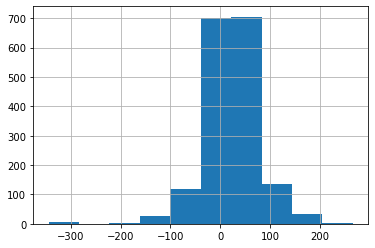

In [8]:
data[data['Currency']=='USD']['Price Premium'].hist()

<AxesSubplot:>

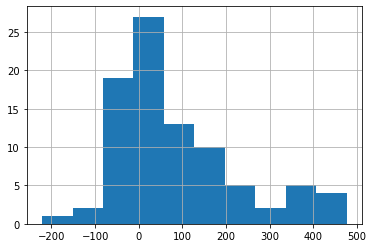

In [9]:
data[data['Currency']!='USD']['Price Premium'].hist()

<b>Removing Outliers</b>

In [13]:
data = data[(np.abs(stats.zscore(data['Price Premium'])) < 3)]

# Customer Segmentation

## Customer

In [14]:
CustomerCode = data.groupby(['Sold to Customer Code']).aggregate({'Price Premium':np.max}).reset_index()
CustomerCode.rename(columns={'Price Premium':'Price Premium per Customer Code'},inplace=True)
CustomerCode

,Sold to Customer Code,Price Premium per Customer Code
0,8010000395,65.00000
1,8010000576,79.17108
2,8010000604,42.64534
3,8010000635,16.43652
4,8010000645,86.00000
...,...,...
143,8010007553,15.00000
144,8010007557,97.00000
145,8010007602,30.30342
146,8010007704,20.00000


In [15]:
Recency = data.groupby(['Sold to Customer Code']).aggregate({'Contract Execution Date':[pd.Series.nunique,np.max]}).reset_index()
Recency.columns = ['Sold to Customer Code','UniqueDays','MostRecentDate']
Recency['today'] = today
Recency['today'] = pd.to_datetime(Recency['today'])
Recency['MostRecentDate'] = pd.to_datetime(Recency['MostRecentDate'])
Recency['days_gap'] = (Recency['today']-Recency['MostRecentDate']).dt.days
Recency = Recency.loc[:,['Sold to Customer Code','UniqueDays','days_gap']]
Recency

,Sold to Customer Code,UniqueDays,days_gap
0,8010000395,1,847
1,8010000576,1,1525
2,8010000604,5,888
3,8010000635,3,433
4,8010000645,26,510
...,...,...,...
143,8010007553,1,693
144,8010007557,1,651
145,8010007602,6,400
146,8010007704,3,400


In [16]:
RFM = pd.merge(CustomerCode,Recency,on=['Sold to Customer Code'],how='inner')
RFM

,Sold to Customer Code,Price Premium per Customer Code,UniqueDays,days_gap
0,8010000395,65.00000,1,847
1,8010000576,79.17108,1,1525
2,8010000604,42.64534,5,888
3,8010000635,16.43652,3,433
4,8010000645,86.00000,26,510
...,...,...,...,...
143,8010007553,15.00000,1,693
144,8010007557,97.00000,1,651
145,8010007602,30.30342,6,400
146,8010007704,20.00000,3,400


## Industry

In [17]:
data['Customer Industry'].unique()

array(['Mfg-Petroleum Prod', 'Trading', 'Mfg-Chemical Product',
       'Mfg-Others', 'EPLS', 'No Customer Industry', 'Petrochemical'],
      dtype=object)

In [18]:
data['Customer Industry'].value_counts(dropna=False)

Mfg-Petroleum Prod      1409
Trading                  251
Mfg-Others                68
Mfg-Chemical Product      54
EPLS                       9
Petrochemical              1
No Customer Industry       1
Name: Customer Industry, dtype: int64

In [19]:
CustomerIndustry = data.groupby(['Customer Industry']).aggregate({'Price Premium':np.max}).reset_index()
CustomerIndustry.rename(columns={'Price Premium':'Price Premium per Customer Industry'},inplace=True)
CustomerIndustry

,Customer Industry,Price Premium per Customer Industry
0,EPLS,47.64103
1,Mfg-Chemical Product,179.03099
2,Mfg-Others,204.15681
3,Mfg-Petroleum Prod,212.72594
4,No Customer Industry,48.00000
5,Petrochemical,65.00000
6,Trading,107.50000


## Customer Type

In [20]:
data['Customer Type'].value_counts(dropna=False)

Distributor / Trader    1045
End Customer             744
No Customer Type           4
Name: Customer Type, dtype: int64

In [21]:
CustomerType = data.groupby(['Customer Type']).aggregate({'Price Premium':np.max}).reset_index()
CustomerType.rename(columns={'Price Premium':'Price Premium per CustomerType'},inplace=True)
CustomerType

,Customer Type,Price Premium per CustomerType
0,Distributor / Trader,181.41252
1,End Customer,212.72594
2,No Customer Type,47.25781


## Segmentation

In [22]:
customer_segmentation = data.copy()
customer_segmentation = customer_segmentation.loc[:,['Sold to Customer Code','Customer Type','Customer Industry']]
customer_segmentation.drop_duplicates(inplace=True)
customer_segmentation

,Sold to Customer Code,Customer Type,Customer Industry
0,8010000770,End Customer,Mfg-Petroleum Prod
1,8010000714,Distributor / Trader,Mfg-Petroleum Prod
2,8010001403,Distributor / Trader,Mfg-Petroleum Prod
3,8010001559,Distributor / Trader,Mfg-Petroleum Prod
4,8010000709,End Customer,Mfg-Petroleum Prod
...,...,...,...
1512,8010007185,Distributor / Trader,Mfg-Others
1516,8010001260,End Customer,Mfg-Petroleum Prod
1534,8010007432,End Customer,Mfg-Petroleum Prod
1570,8010001350,End Customer,Mfg-Petroleum Prod


In [23]:
X = pd.merge(customer_segmentation,RFM,on=['Sold to Customer Code'],how='inner')
X = pd.merge(X,CustomerIndustry,on=['Customer Industry'],how='inner')
X = pd.merge(X,CustomerType,on=['Customer Type'],how='inner')

In [24]:
X.shape

(148, 8)

In [25]:
features = ['Price Premium per Customer Code', 'UniqueDays', 'days_gap',
       'Price Premium per Customer Industry',
       'Price Premium per CustomerType']
X[features]

,Price Premium per Customer Code,UniqueDays,days_gap,Price Premium per Customer Industry,Price Premium per CustomerType
0,103.43304,8,1226,212.72594,212.72594
1,212.72594,24,888,212.72594,212.72594
2,86.00000,26,510,212.72594,212.72594
3,193.16124,10,833,212.72594,212.72594
4,189.98377,15,952,212.72594,212.72594
...,...,...,...,...,...
143,88.00000,10,414,204.15681,181.41252
144,152.78315,3,1168,204.15681,181.41252
145,-38.26534,1,904,204.15681,181.41252
146,20.00000,3,400,212.72594,47.25781


In [26]:
Scaler = StandardScaler()
X_std = Scaler.fit_transform(X[features])
X_std_df = pd.DataFrame(X_std,columns=features)

pca = PCA(random_state=42)
pca_scale = pca.fit_transform(X_std_df)
pca_scale_df = pd.DataFrame(pca_scale)
pca_scale_df.columns = ['PC_'+str(item) for item in pca_scale_df.columns]
pca_scale_df

,PC_0,PC_1,PC_2,PC_3,PC_4
0,-0.479519,-1.185406,-0.083261,0.515255,0.376771
1,1.955690,-1.884415,-1.096590,0.978602,0.159232
2,1.665255,-0.432021,0.064116,-0.915710,0.587262
3,1.032933,-1.664248,-0.777771,0.817324,-0.761413
4,1.113779,-1.734201,-0.828533,0.922468,-0.198982
...,...,...,...,...,...
143,1.097869,0.598053,0.530096,-0.018889,-0.742515
144,-0.050546,-0.611138,-0.141131,1.858697,-0.465891
145,-1.302747,1.323729,1.583467,-0.485744,0.327949
146,1.311244,4.792371,3.350067,3.153675,-1.011434


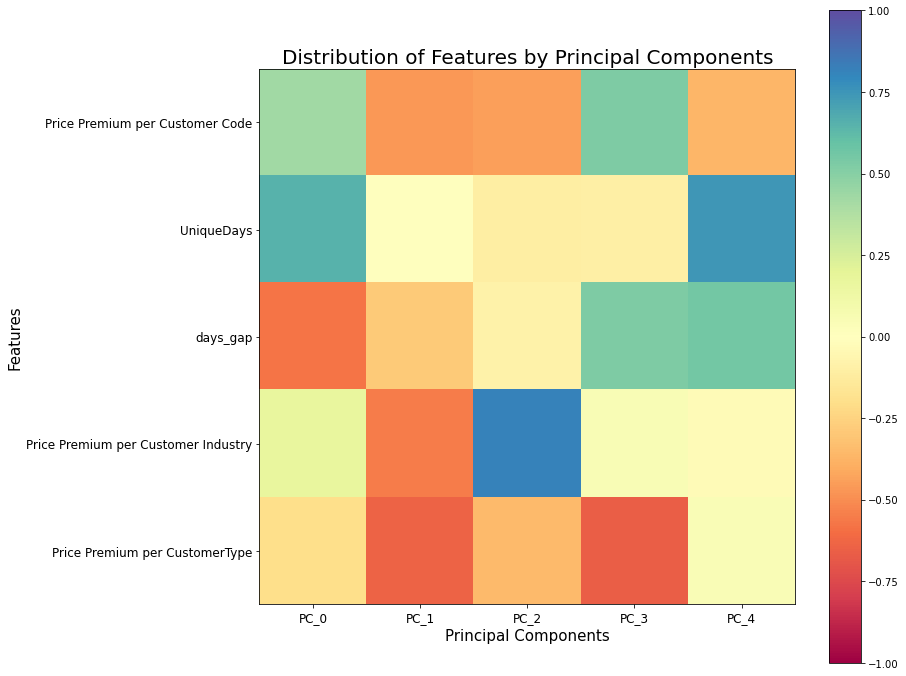

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(pca.components_.T, cmap = 'Spectral', vmin =-1, vmax = 1)

plt.yticks(range(len(features)), features, fontsize=12)
plt.xticks(range(len(pca_scale_df.columns)), pca_scale_df.columns,fontsize=12)
plt.xlabel('Principal Components',
           fontsize=15)
plt.ylabel('Features',
           fontsize=15)
plt.title('Distribution of Features by Principal Components',
          fontsize=20)
plt.colorbar()
plt.show()


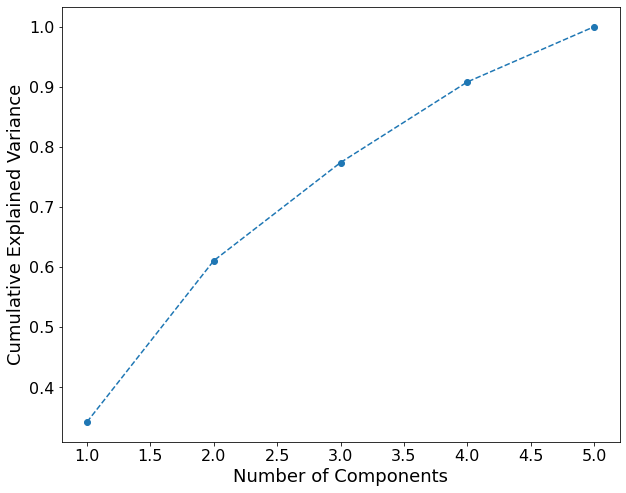

In [28]:
evr = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(features)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [29]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)

Number of components: 4


In [30]:
pca_scale_df.iloc[:,0:n_comps]

,PC_0,PC_1,PC_2,PC_3
0,-0.479519,-1.185406,-0.083261,0.515255
1,1.955690,-1.884415,-1.096590,0.978602
2,1.665255,-0.432021,0.064116,-0.915710
3,1.032933,-1.664248,-0.777771,0.817324
4,1.113779,-1.734201,-0.828533,0.922468
...,...,...,...,...
143,1.097869,0.598053,0.530096,-0.018889
144,-0.050546,-0.611138,-0.141131,1.858697
145,-1.302747,1.323729,1.583467,-0.485744
146,1.311244,4.792371,3.350067,3.153675


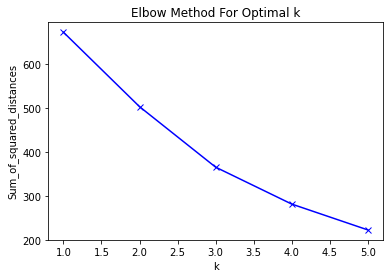

In [31]:
Sum_of_squared_distances = []
K = range(1,6)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(pca_scale_df.iloc[:,0:n_comps])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [32]:
kl = KneeLocator(range(1, 6), Sum_of_squared_distances, curve="convex", direction="decreasing")
print('Suggested number of clusters:',kl.elbow)

if kl.elbow is None or kl.elbow<min_cluster:
    n_clusters = min_cluster
else:
    n_clusters = kl.elbow
    
print('n_clusters:',n_clusters)


Suggested number of clusters: None
n_clusters: 3


/home/cst/anaconda3/lib/python3.8/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


In [33]:
clustering = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_scale_df)

In [34]:
X['Cluster'] = clustering.labels_
X_std_df['Cluster'] = clustering.labels_
pca_scale_df['Cluster'] = clustering.labels_

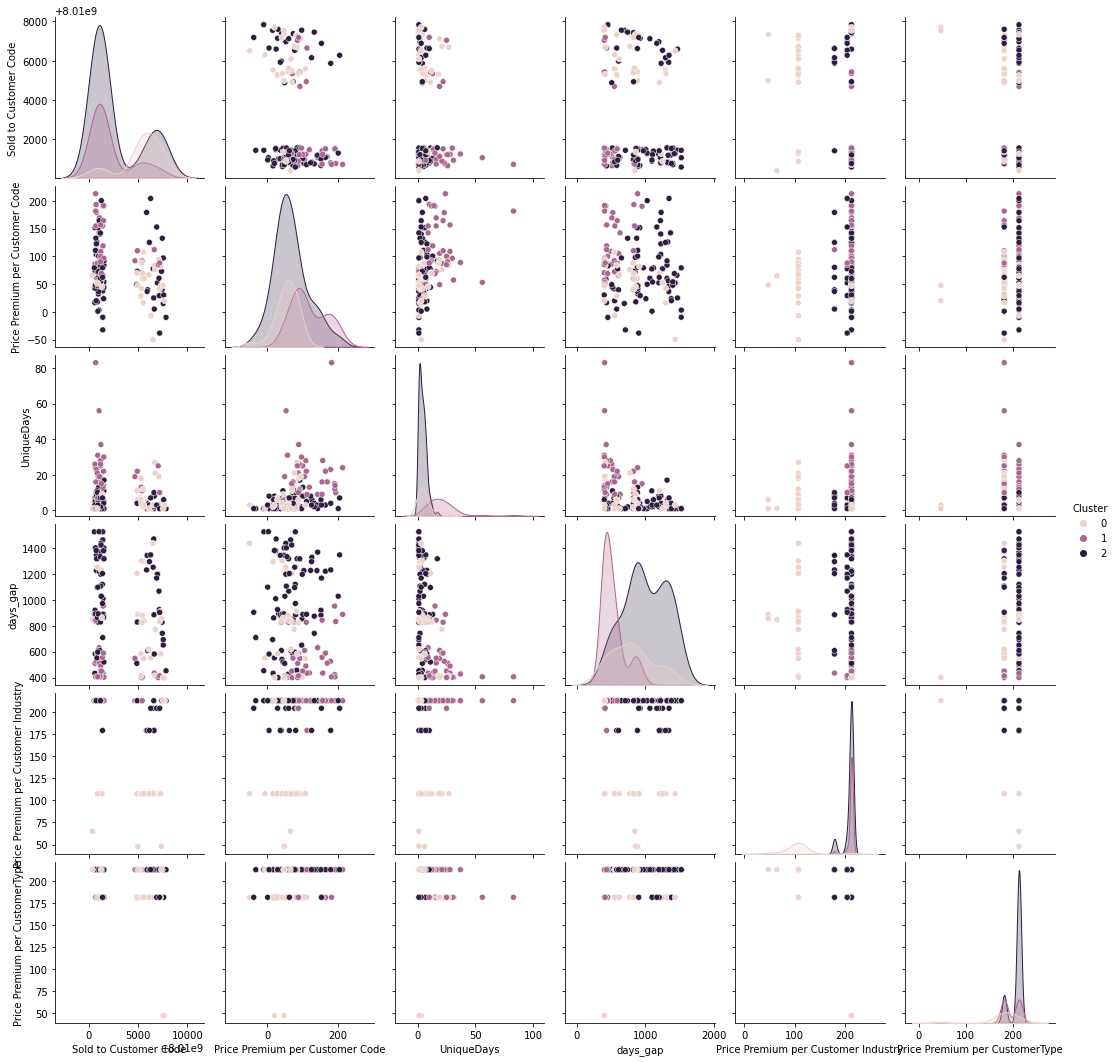

In [35]:
sns.pairplot(X,hue='Cluster')

In [36]:
X['Cluster'].value_counts()

2    84
1    36
0    28
Name: Cluster, dtype: int64

In [37]:
X['Cluster'].value_counts(normalize=True)

2    0.567568
1    0.243243
0    0.189189
Name: Cluster, dtype: float64

Text(0.5, 1.0, 'Customer Segmentation')

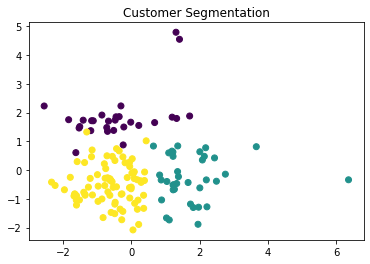

In [38]:
plt.scatter(pca_scale_df['PC_0'],pca_scale_df['PC_1'],c=pca_scale_df['Cluster'])
plt.title('Customer Segmentation')

In [39]:
MinMax = MinMaxScaler()
X_MinMax = MinMax.fit_transform(X[features])
X_MinMax_df = pd.DataFrame(X_MinMax)
X_MinMax_df.columns = features
X_MinMax_df['Cluster'] = clustering.labels_
agg_median = X_MinMax_df.groupby('Cluster').median().reset_index()
agg_median

,Cluster,Price Premium per Customer Code,UniqueDays,days_gap,Price Premium per Customer Industry,Price Premium per CustomerType
0,0,0.406672,0.036585,0.382327,0.362595,0.810759
1,1,0.580606,0.219512,0.038188,1.000000,0.905379
2,2,0.416308,0.036585,0.464032,1.000000,1.000000


<b>There is clear distinction on Premium Price Distribution per Cluster</b>

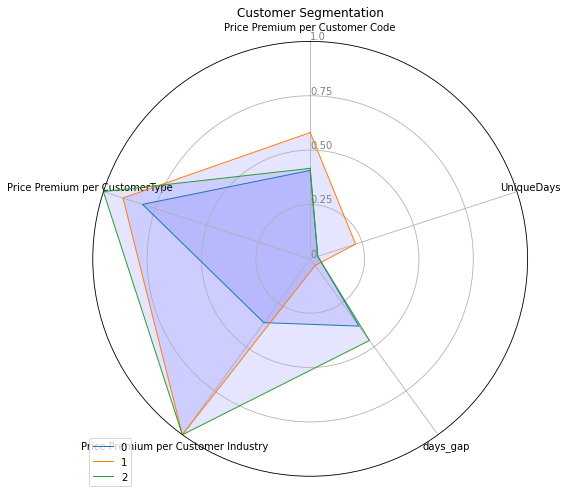

In [40]:
# number of variable
radar_features = features
N_features = len(radar_features)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N_features) * 2 * pi for n in range(N_features)]
angles += angles[:1]
    
# Initialise the spider plot
plt.figure(figsize=(36,8))
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], radar_features)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,0.25,0.50,0.75,1], ["0","0.25","0.50","0.75","1.0"], color="grey", size=10)
plt.ylim(0,1)
 

for label in agg_median['Cluster']:
    
    # Ind
    values=agg_median[agg_median['Cluster']==label][['Cluster']+radar_features]
    del values['Cluster']
    values = values.values.flatten().tolist()
    
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=label)
    ax.fill(angles, values, 'b', alpha=0.1)


# Add legend
plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

plt.title('Customer Segmentation')

# Show the graph
plt.show()





In [41]:
X.rename(columns={'Cluster':'Customer Segment'},inplace=True)

In [42]:
X

,Sold to Customer Code,Customer Type,Customer Industry,Price Premium per Customer Code,UniqueDays,days_gap,Price Premium per Customer Industry,Price Premium per CustomerType,Customer Segment
0,8010000770,End Customer,Mfg-Petroleum Prod,103.43304,8,1226,212.72594,212.72594,2
1,8010000709,End Customer,Mfg-Petroleum Prod,212.72594,24,888,212.72594,212.72594,1
2,8010000645,End Customer,Mfg-Petroleum Prod,86.00000,26,510,212.72594,212.72594,1
3,8010000757,End Customer,Mfg-Petroleum Prod,193.16124,10,833,212.72594,212.72594,1
4,8010001477,End Customer,Mfg-Petroleum Prod,189.98377,15,952,212.72594,212.72594,1
...,...,...,...,...,...,...,...,...,...
143,8010007189,Distributor / Trader,Mfg-Others,88.00000,10,414,204.15681,181.41252,1
144,8010006888,Distributor / Trader,Mfg-Others,152.78315,3,1168,204.15681,181.41252,2
145,8010007185,Distributor / Trader,Mfg-Others,-38.26534,1,904,204.15681,181.41252,2
146,8010007704,No Customer Type,Mfg-Petroleum Prod,20.00000,3,400,212.72594,47.25781,0


In [43]:
company_segment = X[['Sold to Customer Code','Customer Type','Customer Industry','Customer Segment']]
company_segment

,Sold to Customer Code,Customer Type,Customer Industry,Customer Segment
0,8010000770,End Customer,Mfg-Petroleum Prod,2
1,8010000709,End Customer,Mfg-Petroleum Prod,1
2,8010000645,End Customer,Mfg-Petroleum Prod,1
3,8010000757,End Customer,Mfg-Petroleum Prod,1
4,8010001477,End Customer,Mfg-Petroleum Prod,1
...,...,...,...,...
143,8010007189,Distributor / Trader,Mfg-Others,1
144,8010006888,Distributor / Trader,Mfg-Others,2
145,8010007185,Distributor / Trader,Mfg-Others,2
146,8010007704,No Customer Type,Mfg-Petroleum Prod,0


In [44]:
company_segment['Customer Segment'].value_counts()

2    84
1    36
0    28
Name: Customer Segment, dtype: int64

In [45]:
company_segment.to_csv('company_segment_v3B.csv',index=False)

# Product & Transaction Segmentation

In [46]:
data.head()

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer Type,Customer Industry,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,Price Premium Pctg
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000,0.059594
1,2017-11-22,QTN-0000013779-1,1,30012429,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,Distributor / Trader,Mfg-Petroleum Prod,C150Y,72000448,TT60SBLC,CFR,Bangladesh,BDCGP CHITTAGONG,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M059,2018-01-10,2018-01-03,4.22,306.0,MT,USD,1290.0,1235.58130,1288.75,-53.16870,1290.0,41.669931,1279.999931,-0.041256
2,2017-09-11,QTN-0000012648-1,1,30011297,QUOTATION,SUMIKENG (M) SDN BHD,8010001403,Distributor / Trader,Mfg-Petroleum Prod,HD5201AA,72000539,ZM60,DAP,Malaysia,MYPG04 PRAI,MYPG04 PRAI,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,22.0,MT,USD,1170.0,1230.01552,1135.00,95.01552,1160.0,53.080955,1261.000955,0.083714
3,2017-05-15,QTN-0000010801-1,2,30009609,QUOTATION,ZHEJIANG FUTURE PETROCHEMICAL,8010001559,Distributor / Trader,Mfg-Petroleum Prod,C150Y,72000448,LC60,CFR,Hong Kong,HKHKG HONG KONG PORT,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M059,2017-05-31,2017-05-24,0.00,102.0,MT,USD,1190.0,1202.83563,1302.50,-99.66437,1310.0,78.407735,1207.002265,-0.076518
4,2018-08-06,QTN-0000018707-1,1,30016459,QUOTATION,CHONG WAH PLASTICS SDN BHD,8010000709,End Customer,Mfg-Petroleum Prod,LL0209SA,72000608,ZB60,DAP,Malaysia,MYKD01 ALOR SETAR,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-08-31,2018-08-24,4.04,180.0,MT,USD,1190.0,1312.38099,1181.25,131.13099,1210.0,21.566372,1336.996372,0.111010


## Grade

In [47]:
data['Grade'].value_counts(dropna=False)

C150Y       1007
HD5301AA     265
LL0209SA     168
LL3840UA     108
M022X        107
HD5201AA     106
N109X         32
Name: Grade, dtype: int64

In [48]:
data['Grade'].value_counts(dropna=False, normalize=True)

C150Y       0.561629
HD5301AA    0.147797
LL0209SA    0.093698
LL3840UA    0.060234
M022X       0.059677
HD5201AA    0.059119
N109X       0.017847
Name: Grade, dtype: float64

In [49]:
col = 'Grade'
GradePricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
GradePricePremium.rename(columns={'Price Premium':'Price Premium per Grade'},inplace=True)
GradePricePremium

,Grade,Price Premium per Grade
0,C150Y,204.15681
1,HD5201AA,169.20257
2,HD5301AA,138.64267
3,LL0209SA,212.72594
4,LL3840UA,200.20391
5,M022X,193.16124
6,N109X,110.71677


## Material

In [50]:
data['Material'].value_counts(dropna=False)

72000448    1007
72000544     265
72000608     168
72000617     108
72000628     107
72000539     106
72000660      32
Name: Material, dtype: int64

In [51]:
data['Material'].value_counts(dropna=False, normalize=True)

72000448    0.561629
72000544    0.147797
72000608    0.093698
72000617    0.060234
72000628    0.059677
72000539    0.059119
72000660    0.017847
Name: Material, dtype: float64

In [52]:
col = 'Material'
MaterialPricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
MaterialPricePremium.rename(columns={'Price Premium':'Price Premium per Material'},inplace=True)
MaterialPricePremium

,Material,Price Premium per Material
0,72000448,204.15681
1,72000539,169.20257
2,72000544,138.64267
3,72000608,212.72594
4,72000617,200.20391
5,72000628,193.16124
6,72000660,110.71677


## Payment Term

In [53]:
# data['Payment Term'].value_counts(dropna=False)

In [54]:
# col = 'Payment Term'
# PaymentTermPricePremium = data[[col,'Price Premium']].groupby([col]).quantile([0.01,0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 1]).reset_index()
# PaymentTermPricePremium = pd.pivot_table(PaymentTermPricePremium, values='Price Premium',index=[col],columns='level_1').reset_index() 

# prefix = 'PricePremiumPer'+col.replace(' ','')+'Percentile_'
# PaymentTermPricePremium.columns = [col if 'str' in str(type(col)) else str(prefix)+str(col) for col in PaymentTermPricePremium.columns ]
# PaymentTermPricePremium

## Incoterm

In [55]:
# data['Incoterm'].value_counts(dropna=False)

In [56]:
# IncotermMapping = {
#                         'EXW':1,
#                         'FCA':2,
#                         'FAS':3,
#                         'FOB':4,
#                         'CFR':5,
#                         'CIF':5.5,
#                         'CPT':6,
#                         'CIP':6.25,
#                         'DAT':6.50,
#                         'DAP':6.75,
#                         'DDP':7,
#                     }

In [57]:
# col = 'Incoterm'
# IncotermPricePremium = data[[col,'Price Premium']].groupby([col]).quantile([0.01,0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 1]).reset_index()
# IncotermPricePremium = pd.pivot_table(IncotermPricePremium, values='Price Premium',index=[col],columns='level_1').reset_index() 

# prefix = 'PricePremiumPer'+col.replace(' ','')+'Percentile_'
# IncotermPricePremium.columns = [col if 'str' in str(type(col)) else str(prefix)+str(col) for col in IncotermPricePremium.columns ]
# IncotermPricePremium

## Country

In [58]:
data['Country'].unique()

array(['Malaysia', 'Bangladesh', 'Hong Kong', 'China', 'Philippines',
       'Taiwan', 'Thailand', 'Japan', 'Vietnam', 'India', 'Indonesia',
       'Australia', 'Peru', 'Myanmar', 'South Korea', 'Singapore',
       'South Africa', 'Ghana', 'Turkey', 'Pakistan', 'Kenya',
       'Russian Fed.'], dtype=object)

In [59]:
data['Country'].value_counts(dropna=False)

Malaysia        660
Thailand        246
China           208
Indonesia       176
Bangladesh      151
Philippines     131
Vietnam          60
Taiwan           50
India            33
Hong Kong        27
Japan            11
South Africa     10
Myanmar           9
South Korea       5
Singapore         3
Pakistan          3
Ghana             3
Australia         3
Kenya             1
Russian Fed.      1
Turkey            1
Peru              1
Name: Country, dtype: int64

In [60]:
col = 'Country'
CountryPricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
CountryPricePremium.rename(columns={'Price Premium':'Price Premium per Country'},inplace=True)
CountryPricePremium

,Country,Price Premium per Country
0,Australia,53.75726
1,Bangladesh,116.87500
2,China,132.50000
3,Ghana,70.23453
4,Hong Kong,13.48438
5,India,60.00000
6,Indonesia,179.03099
7,Japan,111.98493
8,Kenya,16.66667
9,Malaysia,212.72594


In [61]:
GNI = pd.read_csv('GNI.csv')

In [62]:
GNI

,Rank,Country,Alias,GNI per capita (US$),Year,Group,Group Rank
0,56,Romania,Romania,12570.0,2020.0,Upper-middle-income,3
1,57,Panama,Panama,11880.0,2020.0,Upper-middle-income,3
2,—,World,World,11558.0,2019.0,Upper-middle-income,3
3,58,Costa Rica,Costa Rica,11460.0,2020.0,Upper-middle-income,3
4,59,Russia,Russian Fed.,10690.0,2020.0,Upper-middle-income,3
...,...,...,...,...,...,...,...
213,52,Croatia,Croatia,14190.0,2020.0,High-income,4
214,53,Oman,Oman,14150.0,2019.0,High-income,4
215,—,New Caledonia (France),New Caledonia (France),14020.0,2000.0,High-income,4
216,54,Chile,Chile,13470.0,2020.0,High-income,4


In [63]:
CountryPricePremium = pd.merge(CountryPricePremium,GNI,left_on='Country',right_on='Alias',how='left')

In [64]:
CountryPricePremium.head()

,Country_x,Price Premium per Country,Rank,Country_y,Alias,GNI per capita (US$),Year,Group,Group Rank
0,Australia,53.75726,12,Australia,Australia,53730.0,2020.0,High-income,4.0
1,Bangladesh,116.87500,141,Bangladesh,Bangladesh,2010.0,2020.0,Lower-middle-income,2.0
2,China,132.50000,60,China,China,10610.0,2020.0,Upper-middle-income,3.0
3,Ghana,70.23453,137,Ghana,Ghana,2230.0,2020.0,Lower-middle-income,2.0
4,Hong Kong,13.48438,—,Hong Kong (China),Hong Kong,48630.0,2020.0,High-income,4.0


In [65]:
cols = ['Rank','Country_y','Alias','Year','Group']

for col in cols:

    if col in CountryPricePremium.columns:
        del CountryPricePremium[col]
    
    

In [66]:
CountryPricePremium.rename(columns={'Country_x':'Country'},inplace=True)

In [67]:
MedianIncomeGroup = CountryPricePremium.groupby(['Group Rank']).aggregate({'GNI per capita (US$)':np.median}).reset_index()
MedianIncomeGroup

,Group Rank,GNI per capita (US$)
0,2.0,2010.0
1,3.0,9050.0
2,4.0,48630.0


In [68]:
CountryPricePremium.loc[CountryPricePremium['Country']=='Taiwan','GNI per capita (US$)'] = 48630.0
# CountryPricePremium.loc[CountryPricePremium['Country']=='Taiwan','Group'] = 'High-income'
CountryPricePremium.loc[CountryPricePremium['Country']=='Taiwan','Group Rank'] = 4

In [69]:
CountryPricePremium

,Country,Price Premium per Country,GNI per capita (US$),Group Rank
0,Australia,53.75726,53730.0,4.0
1,Bangladesh,116.87500,2010.0,2.0
2,China,132.50000,10610.0,3.0
3,Ghana,70.23453,2230.0,2.0
4,Hong Kong,13.48438,48630.0,4.0
5,India,60.00000,1900.0,2.0
6,Indonesia,179.03099,3870.0,2.0
7,Japan,111.98493,41580.0,4.0
8,Kenya,16.66667,1760.0,2.0
9,Malaysia,212.72594,10580.0,3.0


## Destination Port

In [70]:
data['Destination Port'].isnull().sum()

0

In [71]:
data['Destination Port'].value_counts(dropna=False)

MYKD01 ALOR SETAR        510
INDONESIA MAIN PORT      172
THBKK BANGKOK            164
BDCGP CHITTAGONG         149
PHMNL MANILA             111
CHINA MAIN PORT          103
MYSG00 KLANG VALLEY       94
THAYU AYUTHAYA            76
CNYTN YANTIAN             42
VNSGN HO CHI MINH         36
HKHKG HONG KONG PORT      27
VNHAP HAI PHONG           22
CNNGB NINGBO              22
MYPG06 PENANG             20
MYPG04 PRAI               19
PHDVO DAVAO               19
INNSA NHAVA SHEVA         18
TAIWAN MAIN PORTS         17
CNSHA SHANGHAI            16
INCCU KOLKATA             14
TWTXG TAICHUNG            13
KAOHSIUNG                 11
ZADUR DURBAN              10
MMRGN YANGON               9
TWKEL KEELUNG              9
CNHUA HUANGPUSUIGANG       9
JPHTD HAKATA               8
THBRK BANGRAK              6
KRICE INCHEON              5
MYMK01 MELAKA              5
CNSWA SHANTOU              4
MYKD05 GURUN               4
MYPR16 KAMUNTING           4
HUANGPU NEW PORT           4
CNXMN XIAMEN  

In [72]:
col = 'Destination Port'
DestinationPortPricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
DestinationPortPricePremium.rename(columns={'Price Premium':'Price Premium per Destination Port'},inplace=True)
DestinationPortPricePremium

,Destination Port,Price Premium per Destination Port
0,"ANY PORT, PERU",-15.81658
1,AUMEL MELBOURNE,53.75726
2,AUSYD SYDNEY,53.75726
3,BANGLADESH,-0.18370
4,BDCGP CHITTAGONG,116.87500
5,CHINA MAIN PORT,69.87675
6,CNHUA HUANGPUSUIGANG,92.08849
7,CNNGB NINGBO,88.00000
8,CNSHA SHANGHAI,88.00000
9,CNSHK SHEKOU,132.50000


## Shipping Condition

In [73]:
data['Shipping Condition'].isnull().sum()

0

In [74]:
col = 'Shipping Condition'
ShippingConditionPricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
ShippingConditionPricePremium.rename(columns={'Price Premium':'Price Premium per Shipping Condition'},inplace=True)
ShippingConditionPricePremium

,Shipping Condition,Price Premium per Shipping Condition
0,MARINE PACK,181.41252
1,TRUCK PACK(Drum),212.72594


## Export/Domestic

In [75]:
data['Export/Domestic'].isnull().sum()

0

In [76]:
col = 'Export/Domestic'
ExportDomesticPricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
ExportDomesticPricePremium.rename(columns={'Price Premium':'Price Premium per Export/Domestic'},inplace=True)
ExportDomesticPricePremium

,Export/Domestic,Price Premium per Export/Domestic
0,DOMESTIC,212.72594
1,EXPORT,191.25000


## Cross Boarder

In [77]:
data['Cross Boarder'].unique()

array(['NONCROSSBORDER', 'CROSSBORDER', 'No Cross Boarder'], dtype=object)

In [78]:
col = 'Cross Boarder'
CrossBorderPricePremium = data.groupby([col]).aggregate({'Price Premium':np.max}).reset_index()
CrossBorderPricePremium.rename(columns={'Price Premium':'Price Premium per Cross Border'},inplace=True)
CrossBorderPricePremium

,Cross Boarder,Price Premium per Cross Border
0,CROSSBORDER,191.25000
1,NONCROSSBORDER,212.72594
2,No Cross Boarder,58.75000


## Plant

In [79]:
# data['Plant'].isnull().sum()

In [80]:
# col = 'Plant'
# PlantPricePremium = data[[col,'Price Premium']].groupby([col]).quantile([0.01,0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 1]).reset_index()
# PlantPricePremium = pd.pivot_table(PlantPricePremium, values='Price Premium',index=[col],columns='level_1').reset_index() 

# prefix = 'PricePremiumPer'+col.replace(' ','').replace('/','')+'Percentile_'
# PlantPricePremium.columns = [col if 'str' in str(type(col)) else str(prefix)+str(col) for col in PlantPricePremium.columns ]
# PlantPricePremium

## Quantity

In [81]:
data['QUANTITY'].isnull().sum()

0

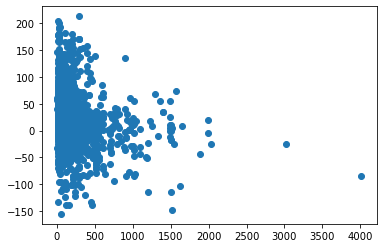

In [82]:
plt.scatter(data['QUANTITY'],data['Price Premium'])

## Grade Alpha

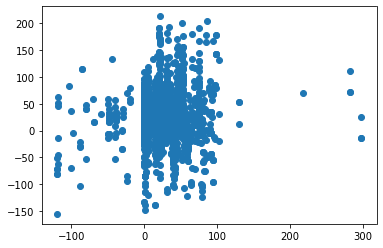

In [83]:
plt.scatter(data['GRADEALPHA'],data['Price Premium'])

## Segmentation

In [84]:
transaction_segmentation = data.copy()
transaction_segmentation.shape

(1793, 34)

In [85]:
transaction_segmentation = pd.merge(transaction_segmentation,GradePricePremium,on=['Grade'],how='inner')
transaction_segmentation = pd.merge(transaction_segmentation,MaterialPricePremium,on=['Material'],how='inner')
# transaction_segmentation = pd.merge(transaction_segmentation,PaymentTermPricePremium,left_on=['Payment Term'],right_on=['Payment Term'],how='inner')
# transaction_segmentation['IncotermLevel'] = transaction_segmentation['Incoterm'].map(IncotermMapping)
# transaction_segmentation = pd.merge(transaction_segmentation,IncotermPricePremium,on=['Incoterm'],how='inner')
transaction_segmentation = pd.merge(transaction_segmentation,CountryPricePremium,on=['Country'],how='inner')
transaction_segmentation = pd.merge(transaction_segmentation,DestinationPortPricePremium,on=['Destination Port'],how='inner')
transaction_segmentation = pd.merge(transaction_segmentation,ShippingConditionPricePremium,on=['Shipping Condition'],how='inner')
transaction_segmentation = pd.merge(transaction_segmentation,ExportDomesticPricePremium,on=['Export/Domestic'],how='inner')
transaction_segmentation = pd.merge(transaction_segmentation,CrossBorderPricePremium,on=['Cross Boarder'],how='inner')
# transaction_segmentation = pd.merge(transaction_segmentation,PlantPricePremium,left_on=['Plant'],right_on=['Plant'],how='inner')
transaction_segmentation.shape

(1793, 43)

In [86]:
transaction_segmentation.head()

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer Type,Customer Industry,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,Price Premium Pctg,Price Premium per Grade,Price Premium per Material,Price Premium per Country,GNI per capita (US$),Group Rank,Price Premium per Destination Port,Price Premium per Shipping Condition,Price Premium per Export/Domestic,Price Premium per Cross Border
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000,0.059594,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594
1,2018-03-07,QTN-0000015960-1,3,30013989,QUOTATION,COMMERCIAL PLASTIC INDUSTRIES,8010000729,Distributor / Trader,Mfg-Petroleum Prod,HD5301AA,72000544,ZM60,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-13,2018-03-06,3.90,572.0,MT,USD,1340.0,1403.21349,1401.25,1.96349,1360.0,23.521096,1430.001096,0.001401,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594
2,2017-09-11,QTN-0000012629-1,1,30011296,QUOTATION,KAMMA KLANG ENTERPRISE SDN BHD,8010000960,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZCBD,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-14,2017-09-07,4.29,22.0,MT,USD,1140.0,1189.09195,1135.00,54.09195,1160.0,20.000000,1212.000000,0.047658,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594
3,2018-03-06,QTN-0000015921-1,4,30013967,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,Distributor / Trader,Mfg-Petroleum Prod,HD5301AA,72000544,ZB60,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-31,2018-03-24,3.90,1100.0,MT,USD,1340.0,1405.06411,1401.25,3.81411,1360.0,21.760548,1430.000548,0.002722,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594
4,2018-03-08,QTN-0000016042-1,1,30014047,QUOTATION,WT PLASTIC PRODUCTS SDN BHD,8010001548,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB60,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-09,2018-03-02,3.90,726.0,MT,USD,1340.0,1405.06411,1401.25,3.81411,1360.0,21.760548,1430.000548,0.002722,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594


In [87]:
list(transaction_segmentation.columns)

['Contract Execution Date',
 'PMT No.',
 'Item No',
 'Sales Contract No.',
 'Contract/Spot',
 'Sold to Customer Name',
 'Sold to Customer Code',
 'Customer Type',
 'Customer Industry',
 'Grade',
 'Material',
 'Payment Term',
 'Incoterm',
 'Country',
 'Destination Port',
 'City State',
 'Shipping Condition',
 'Export/Domestic',
 'Cross Boarder',
 'Plant',
 'RETA',
 'BL Date',
 'EXCHANGE_RATE',
 'QUANTITY',
 'UOM',
 'Currency',
 'FLOOR_PRICE',
 'NORMALISED_INVOICE_PRICE',
 'REFERENCE_MARKET_PRICE',
 'Price Premium',
 'PRODUCTBASEPRICE',
 'GRADEALPHA',
 'INVOICEPRICE',
 'Price Premium Pctg',
 'Price Premium per Grade',
 'Price Premium per Material',
 'Price Premium per Country',
 'GNI per capita (US$)',
 'Group Rank',
 'Price Premium per Destination Port',
 'Price Premium per Shipping Condition',
 'Price Premium per Export/Domestic',
 'Price Premium per Cross Border']

In [88]:
features = ['QUANTITY','GRADEALPHA','Price Premium per Grade',
 'Price Premium per Material',
 'Price Premium per Country',
 'GNI per capita (US$)',
 'Group Rank',
 'Price Premium per Destination Port',
 'Price Premium per Shipping Condition',
 'Price Premium per Export/Domestic',
 'Price Premium per Cross Border']

In [89]:
X = transaction_segmentation[features]

In [90]:
X.isnull().sum().sum()

0

In [91]:
X

,QUANTITY,GRADEALPHA,Price Premium per Grade,Price Premium per Material,Price Premium per Country,GNI per capita (US$),Group Rank,Price Premium per Destination Port,Price Premium per Shipping Condition,Price Premium per Export/Domestic,Price Premium per Cross Border
0,22.0,20.000000,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594
1,572.0,23.521096,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594
2,22.0,20.000000,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594
3,1100.0,21.760548,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594
4,726.0,21.760548,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594
...,...,...,...,...,...,...,...,...,...,...,...
1788,17.0,0.000000,193.16124,193.16124,179.03099,3870.0,2.0,179.03099,181.41252,191.25000,58.75000
1789,51.0,40.000000,204.15681,204.15681,60.00000,1900.0,2.0,50.00000,181.41252,191.25000,58.75000
1790,210.0,40.965714,204.15681,204.15681,60.00000,1900.0,2.0,50.00000,181.41252,191.25000,58.75000
1791,17.0,30.000000,193.16124,193.16124,111.98493,41580.0,4.0,111.98493,181.41252,191.25000,58.75000


In [92]:
Scaler = StandardScaler()
X_std = Scaler.fit_transform(X)

pca = PCA(random_state=42)
pca_scale = pca.fit_transform(X_std)
pca_scale_df = pd.DataFrame(pca_scale)
pca_scale_df.columns = ['PC_'+str(item) for item in pca_scale_df.columns]
pca_scale_df


,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,2.958151,0.495257,-1.556654,0.267239,-0.275976,0.668031,0.297763,0.425437,0.093284,0.257588,-2.966649e-16
1,2.785324,0.070707,-1.965019,-0.122935,1.176862,-0.314398,0.561033,0.478714,0.054907,0.182375,6.698957e-18
2,2.958151,0.495257,-1.556654,0.267239,-0.275976,0.668031,0.297763,0.425437,0.093284,0.257588,7.934218e-15
3,2.593517,-0.337046,-2.392087,-0.564631,2.607219,-1.139530,0.830427,0.518438,0.009140,0.112061,-1.183478e-16
4,2.723099,-0.048266,-2.098080,-0.268047,1.602693,-0.526437,0.643646,0.487529,0.039393,0.162326,6.780934e-17
...,...,...,...,...,...,...,...,...,...,...,...
1788,-0.821609,-1.357670,4.197562,10.762883,6.796810,6.049204,0.695077,-1.527196,2.515479,0.042446,1.101750e-17
1789,-2.589804,-0.513682,4.106333,11.735264,6.121908,4.814289,2.239107,-0.472531,2.334125,-0.454319,-4.342214e-18
1790,-2.640030,-0.636418,3.987923,11.621787,6.542272,4.531476,2.315385,-0.457246,2.322940,-0.476043,2.520262e-17
1791,-0.959069,3.998025,4.375009,10.722278,7.654047,4.766776,0.228758,-1.643649,2.545086,-0.219476,2.266191e-17


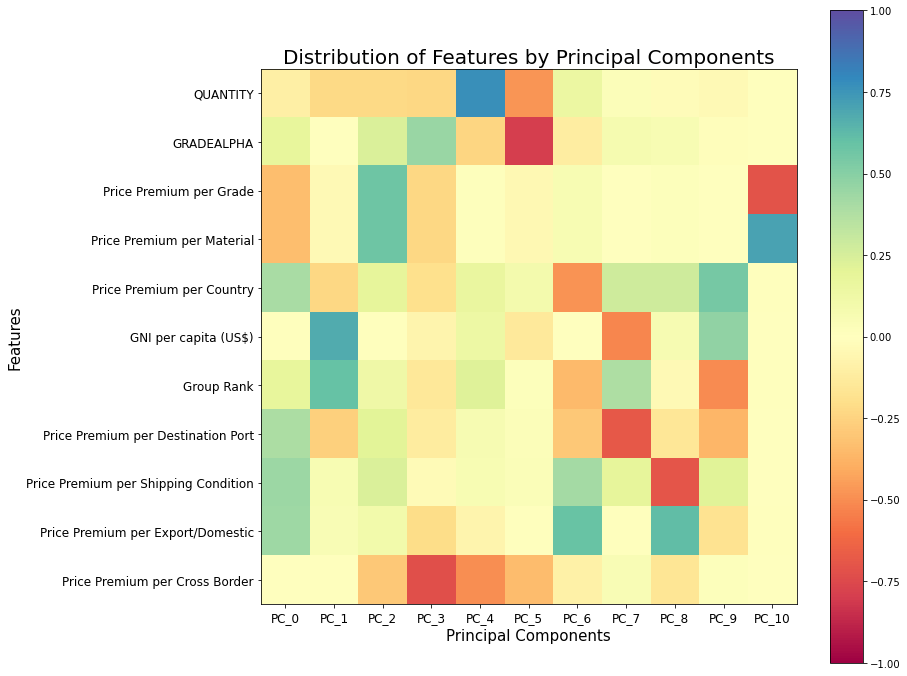

In [93]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(pca.components_.T, cmap = 'Spectral', vmin =-1, vmax = 1)

plt.yticks(range(len(features)), features, fontsize=12)
plt.xticks(range(len(pca_scale_df.columns)), pca_scale_df.columns,fontsize=12)
plt.xlabel('Principal Components',
           fontsize=15)
plt.ylabel('Features',
           fontsize=15)
plt.title('Distribution of Features by Principal Components',
          fontsize=20)
plt.colorbar()
plt.show()


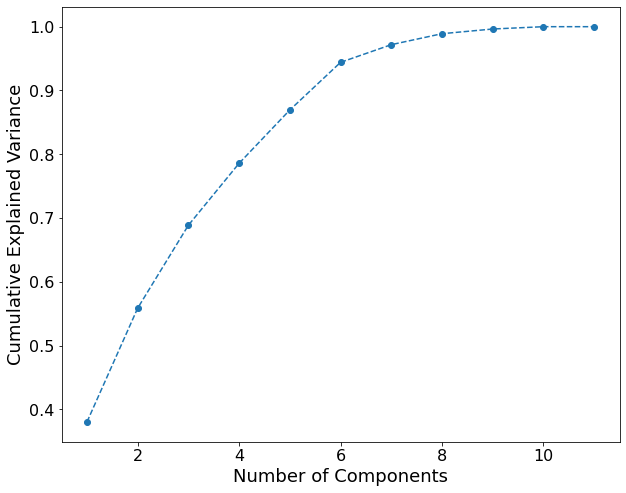

In [94]:
evr = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(features)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [95]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)

Number of components: 5


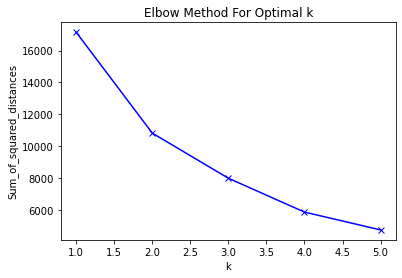

In [96]:
Sum_of_squared_distances = []
K = range(1,6)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(pca_scale_df.iloc[:,0:n_comps])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [97]:
kl = KneeLocator(range(1, 6), Sum_of_squared_distances, curve="convex", direction="decreasing")
print('Suggested number of clusters:',kl.elbow)

if kl.elbow is None or kl.elbow<min_cluster:
    n_clusters = min_cluster
else:
    n_clusters = kl.elbow
    
print('n_clusters:',n_clusters)


Suggested number of clusters: 2
n_clusters: 3


In [98]:
clustering = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_scale_df)

In [99]:
X['transaction_cluster'] = clustering.labels_

<ipython-input-99-7c4d90d18657>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['transaction_cluster'] = clustering.labels_


/home/cst/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/cst/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/cst/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


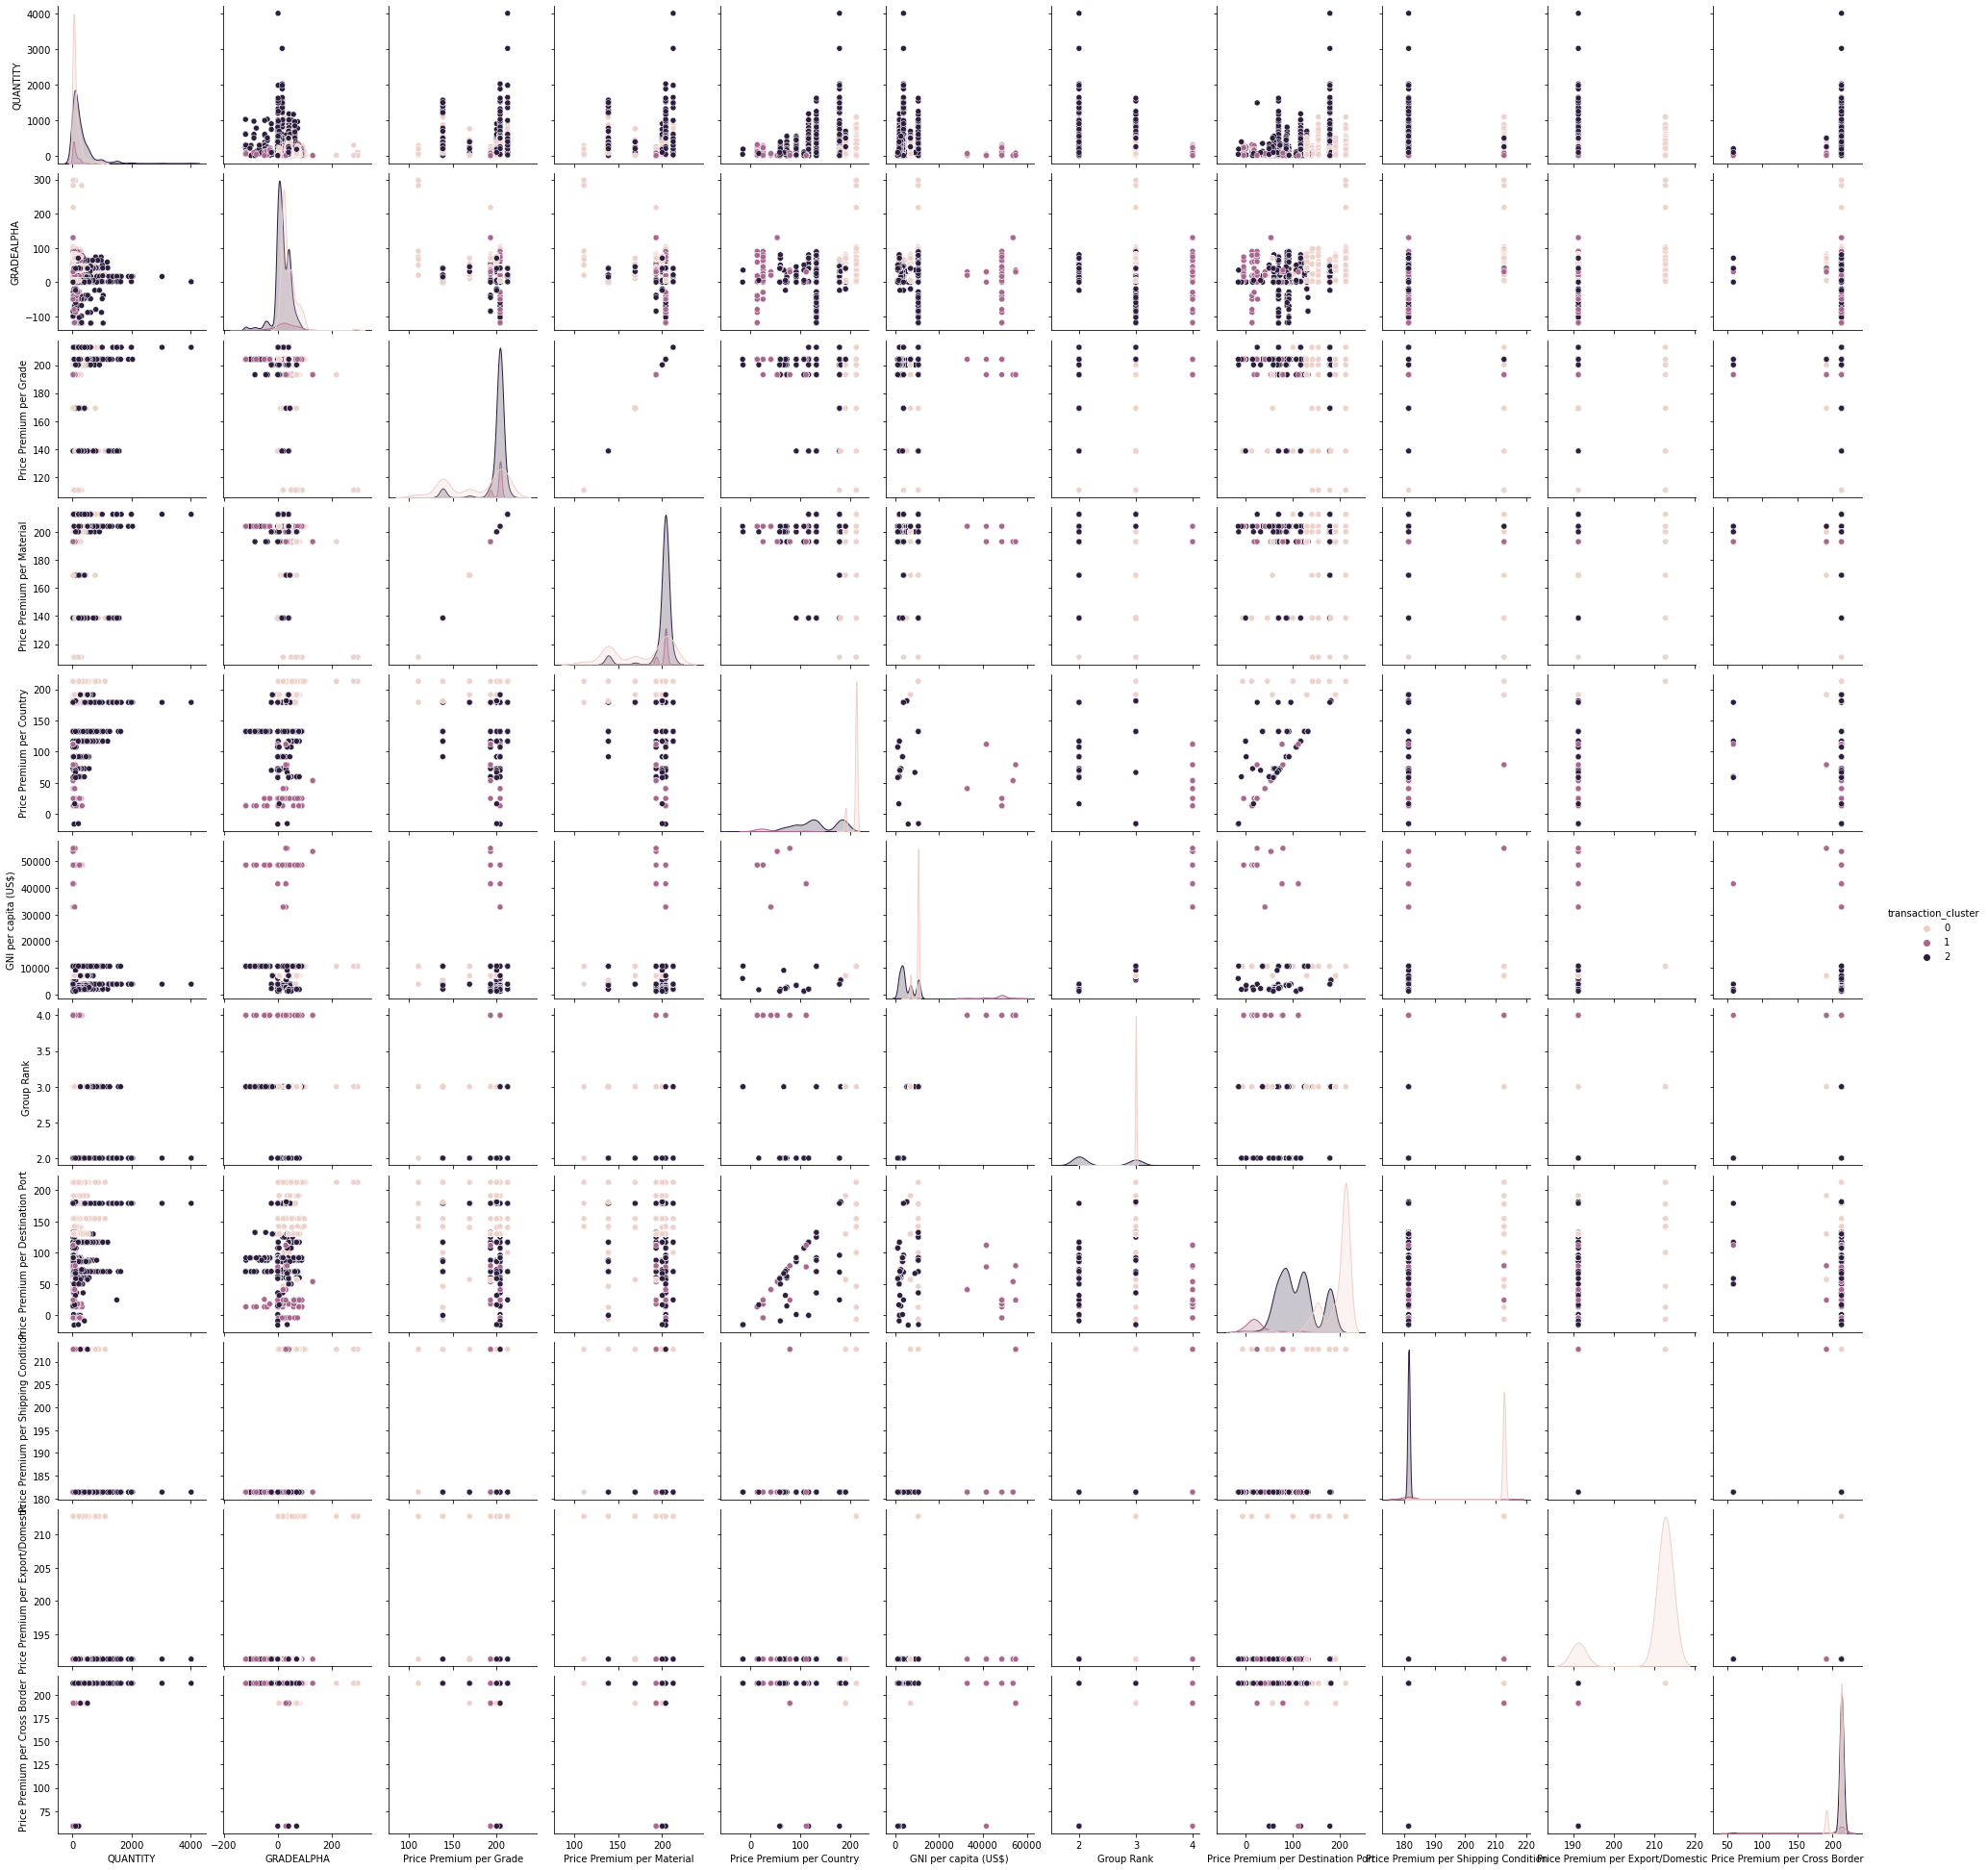

In [100]:
sns.pairplot(X,hue='transaction_cluster')

In [101]:
# X_std_df = pd.DataFrame(X_std,columns=features)
# X_std_df['transaction_cluster'] = clustering.labels_

In [102]:
# sns.pairplot(X_std_df,hue='transaction_cluster')

In [103]:
pca_scale_df['transaction_cluster'] = clustering.labels_

Text(0.5, 1.0, 'Transaction Segmentation')

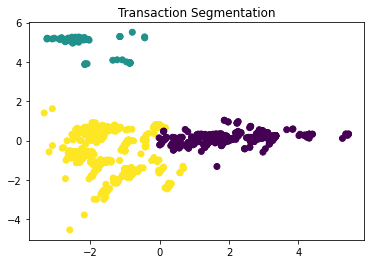

In [104]:
plt.scatter(pca_scale_df['PC_0'],pca_scale_df['PC_1'],c=pca_scale_df['transaction_cluster'])
plt.title('Transaction Segmentation')

In [105]:
MinMax = MinMaxScaler()
X_MinMax = MinMax.fit_transform(X[features])
X_MinMax_df = pd.DataFrame(X_MinMax)
X_MinMax_df.columns = features
X_MinMax_df['label'] = clustering.labels_
agg_median = X_MinMax_df.groupby('label').median().reset_index()
agg_median

,label,QUANTITY,GRADEALPHA,Price Premium per Grade,Price Premium per Material,Price Premium per Country,GNI per capita (US$),Group Rank,Price Premium per Destination Port,Price Premium per Shipping Condition,Price Premium per Export/Domestic,Price Premium per Cross Border
0,0,0.016328,0.342930,0.808206,0.808206,1.000000,0.173686,0.5,1.000000,1.0,1.0,1.0
1,1,0.012589,0.347089,0.915996,0.915996,0.179775,0.882780,1.0,0.147966,0.0,0.0,1.0
2,2,0.033778,0.323152,0.915996,0.915996,0.648967,0.048640,0.0,0.580599,0.0,0.0,1.0


In [106]:
transaction_segmentation['Transaction Cluster'] = clustering.labels_

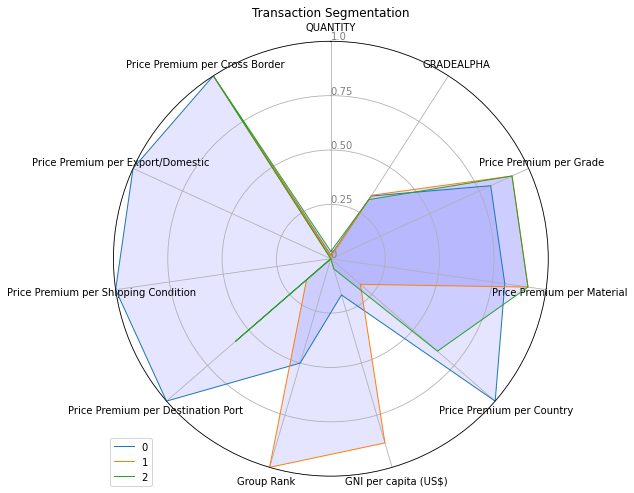

In [107]:
# number of variable
radar_features = features
N_features = len(features)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N_features) * 2 * pi for n in range(N_features)]
angles += angles[:1]
    
# Initialise the spider plot
plt.figure(figsize=(36,8))
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], radar_features)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,0.25,0.50,0.75,1], ["0","0.25","0.50","0.75","1.0"], color="grey", size=10)
plt.ylim(0,1)
 

for label in agg_median['label']:
    
    # Ind
    values=agg_median[agg_median['label']==label][['label']+radar_features]
#     .drop('simple_cluster_4_label').values.flatten().tolist()
    del values['label']
#     values.drop('simple_cluster_4_label')
#     .drop('simple_cluster_4_label').values.flatten().tolist()
#     print(type(values))
    values = values.values.flatten().tolist()
    
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=label)
    ax.fill(angles, values, 'b', alpha=0.1)


# Add legend
plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

plt.title('Transaction Segmentation')

# Show the graph
plt.show()

In [108]:
transaction_segmentation['Transaction Cluster'].value_counts()

2    929
0    765
1     99
Name: Transaction Cluster, dtype: int64

In [109]:
transaction_segmentation['Transaction Cluster'].value_counts(normalize=True)

2    0.518126
0    0.426659
1    0.055215
Name: Transaction Cluster, dtype: float64

In [110]:
transaction_segmentation.to_csv('transaction_segmentation_v3B.csv',index=False)

# Price Segmentation

In [111]:
company_segmentation = pd.read_csv('company_segment_v3B.csv')
transaction_segmentation = pd.read_csv('transaction_segmentation_v3B.csv')

In [112]:
data.shape, transaction_segmentation.shape, company_segmentation.shape

((1793, 34), (1793, 44), (148, 4))

In [113]:
company_segmentation.head()

,Sold to Customer Code,Customer Type,Customer Industry,Customer Segment
0,8010000770,End Customer,Mfg-Petroleum Prod,2
1,8010000709,End Customer,Mfg-Petroleum Prod,1
2,8010000645,End Customer,Mfg-Petroleum Prod,1
3,8010000757,End Customer,Mfg-Petroleum Prod,1
4,8010001477,End Customer,Mfg-Petroleum Prod,1


In [114]:
transaction_segmentation.head()

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer Type,Customer Industry,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,Price Premium Pctg,Price Premium per Grade,Price Premium per Material,Price Premium per Country,GNI per capita (US$),Group Rank,Price Premium per Destination Port,Price Premium per Shipping Condition,Price Premium per Export/Domestic,Price Premium per Cross Border,Transaction Cluster
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000,0.059594,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594,0
1,2018-03-07,QTN-0000015960-1,3,30013989,QUOTATION,COMMERCIAL PLASTIC INDUSTRIES,8010000729,Distributor / Trader,Mfg-Petroleum Prod,HD5301AA,72000544,ZM60,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-13,2018-03-06,3.90,572.0,MT,USD,1340.0,1403.21349,1401.25,1.96349,1360.0,23.521096,1430.001096,0.001401,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594,0
2,2017-09-11,QTN-0000012629-1,1,30011296,QUOTATION,KAMMA KLANG ENTERPRISE SDN BHD,8010000960,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZCBD,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-14,2017-09-07,4.29,22.0,MT,USD,1140.0,1189.09195,1135.00,54.09195,1160.0,20.000000,1212.000000,0.047658,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594,0
3,2018-03-06,QTN-0000015921-1,4,30013967,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,Distributor / Trader,Mfg-Petroleum Prod,HD5301AA,72000544,ZB60,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-31,2018-03-24,3.90,1100.0,MT,USD,1340.0,1405.06411,1401.25,3.81411,1360.0,21.760548,1430.000548,0.002722,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594,0
4,2018-03-08,QTN-0000016042-1,1,30014047,QUOTATION,WT PLASTIC PRODUCTS SDN BHD,8010001548,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB60,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-09,2018-03-02,3.90,726.0,MT,USD,1340.0,1405.06411,1401.25,3.81411,1360.0,21.760548,1430.000548,0.002722,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594,0


In [115]:
X = pd.merge(company_segmentation,transaction_segmentation,on=['Sold to Customer Code','Customer Industry','Customer Type'], how='inner')

In [116]:
X.shape

(1793, 45)

In [117]:
X

,Sold to Customer Code,Customer Type,Customer Industry,Customer Segment,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,Price Premium Pctg,Price Premium per Grade,Price Premium per Material,Price Premium per Country,GNI per capita (US$),Group Rank,Price Premium per Destination Port,Price Premium per Shipping Condition,Price Premium per Export/Domestic,Price Premium per Cross Border,Transaction Cluster
0,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.00,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.0,1177.0,0.059594,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594,0
1,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-07-12,QTN-0000011800-1,1,30010584,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-07-14,2017-07-07,4.25,44.00,MT,USD,1110.0,1122.00926,1100.00,22.00926,1130.0,20.0,1148.0,0.020008,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594,0
2,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-10-05,QTN-0000013133-1,1,30011699,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-10-09,2017-10-02,4.20,22.00,MT,USD,1190.0,1264.88585,1193.00,71.88585,1210.0,20.0,1291.0,0.060256,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594,0
3,8010000770,End Customer,Mfg-Petroleum Prod,2,2017-09-06,QTN-0000012584-1,1,30011256,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,44.00,MT,USD,1140.0,1208.93418,1135.00,73.93418,1160.0,20.0,1235.0,0.065140,138.64267,138.64267,212.72594,10580.0,3.0,154.61475,212.72594,212.72594,212.72594,0
4,8010000770,End Customer,Mfg-Petroleum Prod,2,2018-03-07,QTN-0000015928-1,1,30014021,QUOTATION,DURA-MINE SDN BHD.,HD5301AA,72000544,ZB30,DAP,Malaysia,MYKD01 ALOR SETAR,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-03-13,2018-03-06,3.90,22.00,MT,USD,1340.0,1504.68304,1401.25,103.43304,1360.0,20.0,1526.0,0.073815,138.64267,138.64267,212.72594,10580.0,3.0,212.72594,212.72594,212.72594,212.72594,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,8010007185,Distributor / Trader,Mfg-Others,2,2019-01-23,QTN-0000021929-2,1,30019680,QUOTATION,MEGA VINA COMPANY LIMITED,C150Y,72000448,TT00,CIF,Vietnam,VNSGN HO CHI MINH,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M169,2019-01-31,NaN,4.16,306.00,MT,USD,1000.0,1001.73466,1040.00,-38.26534,1040.0,5.0,1005.0,-0.036794,204.15681,204.15681,73.00000,2660.0,2.0,60.00000,181.41252,191.25000,212.72594,2
1789,8010007704,No Customer Type,Mfg-Petroleum Prod,0,2020-06-10,QTN-0000031921-1,1,30029481,QUOTATION,HYOSUNG TNC CORPORATION,C150Y,72000448,LC00,CFR,South Korea,KRICE INCHEON,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M169,2020-06-30,2020-06-23,4.34,49.50,MT,USD,746.0,868.00000,848.00,20.00000,746.0,20.0,870.0,0.023585,204.15681,204.15681,41.00000,32860.0,4.0,41.00000,181.41252,191.25000,212.72594,1
1790,8010007704,No Customer Type,Mfg-Petroleum Prod,0,2020-02-12,QTN-0000029709-1,1,30027268,QUOTATION,HYOSUNG TNC CORPORATION,C150Y,72000448,LC00,CFR,South

In [118]:
final = X[['Customer Segment','Transaction Cluster','Price Premium']]

In [119]:
final.to_csv('final_v3B.csv',index=False)

In [120]:
final['Label'] = 'Company Segment: '+final['Customer Segment'].astype(str)+', Transaction Segment: '+final['Transaction Cluster'].astype(str)

<ipython-input-120-f0ccaa8a8f29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['Label'] = 'Company Segment: '+final['Customer Segment'].astype(str)+', Transaction Segment: '+final['Transaction Cluster'].astype(str)


In [121]:
final

,Customer Segment,Transaction Cluster,Price Premium,Label
0,2,0,64.73423,"Company Segment: 2, Transaction Segment: 0"
1,2,0,22.00926,"Company Segment: 2, Transaction Segment: 0"
2,2,0,71.88585,"Company Segment: 2, Transaction Segment: 0"
3,2,0,73.93418,"Company Segment: 2, Transaction Segment: 0"
4,2,0,103.43304,"Company Segment: 2, Transaction Segment: 0"
...,...,...,...,...
1788,2,2,-38.26534,"Company Segment: 2, Transaction Segment: 2"
1789,0,1,20.00000,"Company Segment: 0, Transaction Segment: 1"
1790,0,1,-13.00000,"Company Segment: 0, Transaction Segment: 1"
1791,0,1,-11.00000,"Company Segment: 0, Transaction Segment: 1"


Text(0.5, 1.0, 'Price Segmentation')

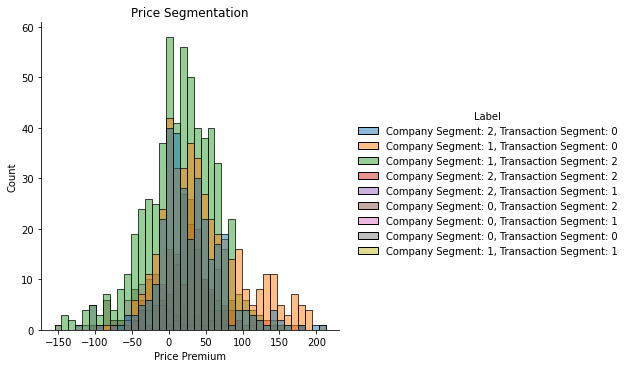

In [124]:
sns.displot(data=final, x="Price Premium", hue="Label",alpha=0.5)
plt.title('Price Segmentation')

Text(0.5, 1.0, 'Price Segmentation')

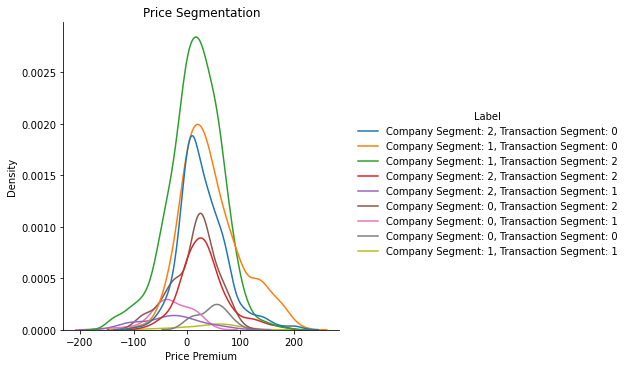

In [125]:
sns.displot(data=final, x="Price Premium", hue="Label",alpha=0.5,kind='kde')
plt.title('Price Segmentation')